In [567]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import random

seed_num = 42
np.random.seed(seed_num)
random.seed(seed_num)
tf.random.set_seed(seed_num)

In [568]:
#데이터 가져오기
data = pd.read_csv('samsung.csv')

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,50800,51780,50800,50840,43719.54688,12868600
1,2017-12-04,50840,51340,50020,51340,44149.51953,14865050
2,2017-12-05,50600,51300,50280,51260,44080.72656,9326550
3,2017-12-06,51260,51560,50020,50020,43014.37500,10889200
4,2017-12-07,50040,50980,50020,50740,43633.54688,11065600


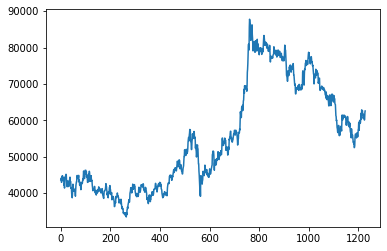

In [569]:
#원본 데이터 출력
plt.plot(data['Adj Close'], label='Adj Close')

plt.show()

In [570]:
# 원본 데이터의 정보 출력

data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1.228000e+03
mean,58672.198697,59218.916938,58108.021173,58642.467427,55159.411356,1.561979e+07
std,13340.045603,13411.046319,13265.745450,13313.072735,14441.999633,8.432601e+06
min,37450.000000,37600.000000,36850.000000,37450.000000,33533.847660,0.000000e+00
25%,47150.000000,47550.000000,46600.000000,47137.500000,42108.180665,1.024662e+07
50%,55550.000000,56200.000000,54950.000000,55450.000000,51871.818360,1.379800e+07
75%,70200.000000,70525.000000,69725.000000,70100.000000,68582.289060,1.857676e+07
max,90300.000000,96800.000000,89500.000000,91000.000000,87764.796880,9.030618e+07


In [571]:
# 각 column에 null인 값이 있는지 확인

data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [572]:
# 각 column에 0이 몇개인지 확인

for col in data.columns:
    missing_rows = data.loc[data[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 16


In [573]:
# Volume의 값이 0이면 NaN으로 바꿈

data['Volume'] = data['Volume'].replace(0, np.nan)

In [574]:
# 각 column에 0인 값이 몇 개인지 확인

for col in data.columns:

    missing_rows = data.loc[data[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 0


In [575]:
# 각 column에 null인 값이 몇 개인지 확인

data.isnull().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume       16
dtype: int64

In [576]:
#각 행에 null인 값이 있는지 확인
data.isnull().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume        True
dtype: bool

In [577]:
#Open column에 na값이 있는 행 출력
data.loc[data['Open'].isna()]

,Date,Open,High,Low,Close,Adj Close,Volume


In [578]:
# na값이 있는 행 삭제

data = data.dropna()

# 각 column의 null 개수 출력
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [579]:
# Date column을 제외한 나머지 column들을 정규화

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
scaled = scaler.fit_transform(data[scale_cols])
scaled = pd.DataFrame(scaled, columns=scale_cols)

print(scaled)

          Open      High       Low     Close  Adj Close    Volume
0     0.252602  0.239527  0.264957  0.250047   0.187821  0.098511
1     0.253359  0.232095  0.250142  0.259384   0.195749  0.121753
2     0.248817  0.231419  0.255081  0.257890   0.194481  0.057276
3     0.261306  0.235811  0.250142  0.234734   0.174818  0.075468
4     0.238221  0.226014  0.250142  0.248179   0.186235  0.077521
...        ...       ...       ...       ...        ...       ...
1207  0.453169  0.407095  0.454891  0.439776   0.506466  0.026443
1208  0.436140  0.386824  0.435897  0.422969   0.489871  0.048691
1209  0.424787  0.388514  0.435897  0.432306   0.499091  0.030357
1210  0.434248  0.415541  0.443495  0.462185   0.528594  0.178841
1211  0.485336  0.432432  0.483381  0.469655   0.535970  0.111700

[1212 rows x 6 columns]


In [580]:
# 특징 데이터와 label 데이터를 입력받아 시계열 데이터를 만든다.
# shifting을 하여 window를 생성한다.

def make_sequence(feature, label, window):

    feature_list = []
    label_list = []

    # window 크기만큼의 데이터들을 특징 리스트의 각 항목에 저장하고 마지막의 다음 값을 label 리스트에 저장한다.
    for i in range(len(feature)-window):

        feature_list.append(feature[i:i+window])
        label_list.append(label[i+window])

    return np.array(feature_list), np.array(label_list)

In [581]:
# 주가예측을 위한 특징 데이터로 Adj Close를 사용한다. label 데이터 또한 Adj Close로 사용한다.

feature_cols = [ 'Adj Close' ]
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled, columns=feature_cols)
label_df = pd.DataFrame(scaled, columns=label_cols)

In [582]:
# Pandas의 dataframe에서 numpy로 변환한다.

feature = feature_df.to_numpy()
label = label_df.to_numpy()

In [583]:
# 특징 데이터와 label을 사용하여 시계열 데이터를 생성한다.
window = 40

X, Y = make_sequence(feature, label, window)

In [584]:
# 훈련 데이터와 테스트 데이터를 8:2 비율로 분리한다.

split = int(len(X)*0.8)

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

In [585]:
# 레이어를 선형으로 연결하여 구성하기 위해 Sequential 모델을 생성한다.

model = Sequential()

#활성함수로는 ReLU 대신 tanh를 사용한다.
model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape))
model.add(Dense(1, activation='linear'))

In [586]:
#손실함수로는 평균제곱오차를, 옵티마이저로는 adam을 사용한다.
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 128)               66560     
                                                                 
 dense_24 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [587]:
#특정 조건에 도달하면 종료하기 위해 EarlyStopping을 사용한다.
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=100, batch_size=16,
          callbacks=[early_stop])

Epoch 1/100
59/59 [==============================] - 4s 36ms/step - loss: 0.0201 - mae: 0.0850 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 2/100
59/59 [==============================] - 2s 28ms/step - loss: 0.0014 - mae: 0.0268 - val_loss: 9.7972e-04 - val_mae: 0.0248
Epoch 3/100
59/59 [==============================] - 2s 28ms/step - loss: 0.0013 - mae: 0.0257 - val_loss: 9.1660e-04 - val_mae: 0.0239
Epoch 4/100
59/59 [==============================] - 2s 29ms/step - loss: 0.0012 - mae: 0.0248 - val_loss: 8.9794e-04 - val_mae: 0.0240
Epoch 5/100
59/59 [==============================] - 2s 32ms/step - loss: 0.0012 - mae: 0.0262 - val_loss: 7.9057e-04 - val_mae: 0.0222
Epoch 6/100
59/59 [==============================] - 2s 28ms/step - loss: 0.0011 - mae: 0.0245 - val_loss: 8.1161e-04 - val_mae: 0.0225
Epoch 7/100
59/59 [==============================] - 2s 29ms/step - loss: 0.0010 - mae: 0.0238 - val_loss: 8.2782e-04 - val_mae: 0.0229
Epoch 8/100
59/59 [==============================] -

8/8 [==============================] - 1s 17ms/step


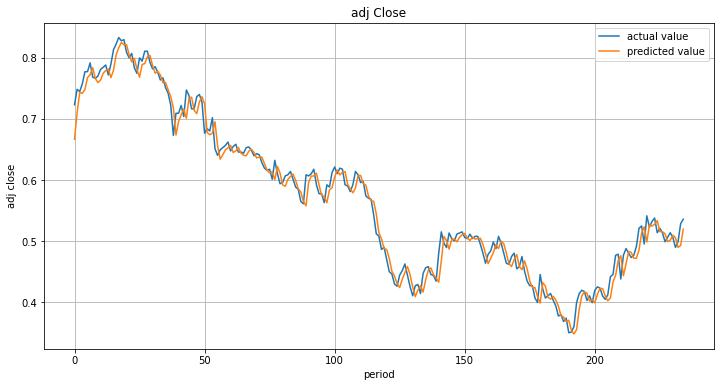

In [588]:
pred = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('adj Close')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual value')
plt.plot(pred, label='predicted value')
plt.grid()
plt.legend(loc='best')

plt.show()

In [589]:
# 평균 절대 백분율 오차를 계산한다.

print( np.sum(abs(y_test-pred)/y_test) / len(x_test) )

0.02516224327821375
